# KOI 1961

In [2]:
import orbitize
import matplotlib.pyplot as plt
import numpy as np
from orbitize import read_input, system, priors, sampler
plt.style.use('katie')
%matplotlib inline

### Ortbitize input file

You can provide your observations in one of the following valid sets of measurements using the corresponding column names:

RA and DEC offsets [milliarcseconds], using column names raoff, raoff_err, decoff, and decoff_err; or

sep [milliarcseconds] and PA [degrees East of NCP], using column names sep, sep_err, pa, and pa_err; or

RV measurement [km/s] using column names rv and rv_err.

Each row must also have a column for epoch and object. Epoch is the date of the observation, in MJD (JD-2400000.5). If this method thinks you have provided a date in JD, it will print a warning and attempt to convert to MJD. Objects are numbered with integers, where the primary/central object is 0.

You may mix and match these three valid measurement formats in the same input file. So, you can have some epochs with RA/DEC offsets and others in separation/PA measurements.

If you have, for example, one RV measurement of a star and three astrometric measurements of an orbiting planet, you should put 0 in the object column for the RV point, and 1 in the columns for the astrometric measurements.

In [3]:
# Input file
path_to_file = '/Users/kvlester/Research/orbits/KOI_1961/orbitize/data.csv'
print(path_to_file)

from orbitize import read_input
data_table = read_input.read_file(path_to_file)
data_table

/Users/kvlester/Research/orbits/KOI_1961/orbitize/data.csv


epoch,object,quant1,quant1_err,quant2,quant2_err,quant12_corr,quant_type,instrument
float64,int64,float64,float64,float64,float64,float64,bytes5,bytes5
56869.49,1,34.6,2.0,257.6,1.2,nan,seppa,defsp
57224.39,1,36.99,1.5,261.02,1.29,nan,seppa,defsp
57699.21,1,40.0,4.0,263.0,1.8,nan,seppa,defsp
57935.5,1,42.17,1.8,267.5,1.4,nan,seppa,defsp
59389.49,1,46.8,2.0,275.17,2.45,nan,seppa,defsp
59502.24,1,44.9,2.5,276.67,3.82,nan,seppa,defsp
59709.55,1,47.0,3.5,277.6,3.7,nan,seppa,defsp


In [4]:
# not plotting observations for some reason
sep = data_table['quant1']
pa = data_table['quant2'] * np.pi/180
esep = data_table['quant1_err']

ra = sep * np.sin(pa)
dec = sep * np.cos(pa)
era = esep
edec = esep

### Orbital parameters 

Here are the possible string labels for this fit that you can enter for param_list and the corresponding orbit fit parameter:

sma1 = semimajor axis

ecc1 = eccentricity

inc1 = inclination

aop1 = argument of periastron *of the planet's orbit!*

pan1 = longitude of ascending node *of the planet's orbit!*

tau1 = epoch of periastron passage (expressed as a fraction of orbital period past a specified offset. See details [here](https://orbitize.readthedocs.io/en/latest/faq/Time_Of_Periastron.html))

mtot = system mass

plx = system parallax

Note: for labels with numbers, the number corresponds to the companion (sma1 is the first object’s semimajor axis, sma2 would be the second object, etc)

### A Caution to RV Astronomers:
orbitize! defines $\omega$ to be the argument of periastron of the planet’s orbit ($\omega_B$), wheras most RV codes (e.g. radvel) define $\omega$ to be the argument of periastron of the star’s orbit ($\omega_A$). In practice, this means that you need to add 180 deg when comparing the outputs of RV codes and orbitize!.

In [5]:
# Set up system

# number of secondary bodies in system
num_planets = 1

# total mass & error [msol]
total_mass = 1.10    # 0.90+0.20
mass_err = 0.50

# parallax & error [mas]
plx = 2.4701
plx_err =  0 #  TESTING WITH FIXED PARALLAX     0.0253

# Create system object with info
sys = system.System(
    num_planets, data_table, total_mass,
    plx, mass_err=mass_err, plx_err=plx_err
)

print(sys.labels)
print(sys.sys_priors)
print(sys.param_idx)

# alias for convenience
lab = sys.param_idx

['sma1', 'ecc1', 'inc1', 'aop1', 'pan1', 'tau1', 'plx', 'mtot']
[Log Uniform, Uniform, Sine, Uniform, Uniform, Uniform, 2.4701, Gaussian]
{'sma1': 0, 'ecc1': 1, 'inc1': 2, 'aop1': 3, 'pan1': 4, 'tau1': 5, 'plx': 6, 'mtot': 7}


The System object has a few handy attributes to help you keep track of your fitting parameters. System.labels is a list of the names of your fit parameters, and System.sys_priors is a list of the priors on each parameter. Notice that the “prior” on parallax (plx) is just a float. That’s because we fixed this parameter at the printed value by specifying that plx_err=0.

System.param_idx is a dictionary that maps the parameter names from System.labels to their indices in System.sys_priors.

Priors in orbitize are Python objects. You can view an exhaustive list here. Let’s print out the attributes of some of our priors:

In [6]:
# Changing priors

# LONGITUDE OF ASCENDING NODe  currently
# print(vars(sys.sys_priors[lab['pan1']]))   # 0-2pi = 0-360deg

# new gaussian prior
mu = 113 * np.pi/180.   
sigma = 30 * np.pi/180.
sys.sys_priors[lab['pan1']] = priors.GaussianPrior(mu, sigma)






# LONGITUDE OF PERIASTRON OF THE COMPANION (B)
# new gaussian prior
mu = 330 * np.pi/180.   
sigma = 30 * np.pi/180.
sys.sys_priors[lab['aop1']] = priors.GaussianPrior(mu, sigma)



## new uniform prior
#min = 100 * np.pi/180
#max = 200 * np.pi/180
#sys.sys_priors[lab['pan1']] = priors.UniformPrior(min, max)

# Fix the inclination
#sys.sys_priors[lab['inc1']] = 2.5


In [7]:
# Setup sampler
s = sampler.OFTI(sys)

# number of orbits to accept
#   OFTI should accept a minimum of 10,000 orbit for convergence!
#   For publication plots, we recommend at least 1,000,000 accepted orbits.
n_orbs = 100000


# Run sampler
if 0 == 1:
    orbits = s.run_sampler(n_orbs)    # run sampler
    myResults = s.results             # get results
    myResults.save_results('results.hdf5')    # save to file
else:
    import orbitize.results
    myResults = orbitize.results.Results() # create empty Results object
    myResults.load_results('results.hdf5') # load from file
    orbits = myResults.post    # pull out accepted orbits

# array of MxN array of orbital parameters (M orbits with N parameters per orbit)
#print(len(orbits[:,0]))
# if not finding orbits, try increasing error bars!
    

100000


<Figure size 1008x432 with 0 Axes>

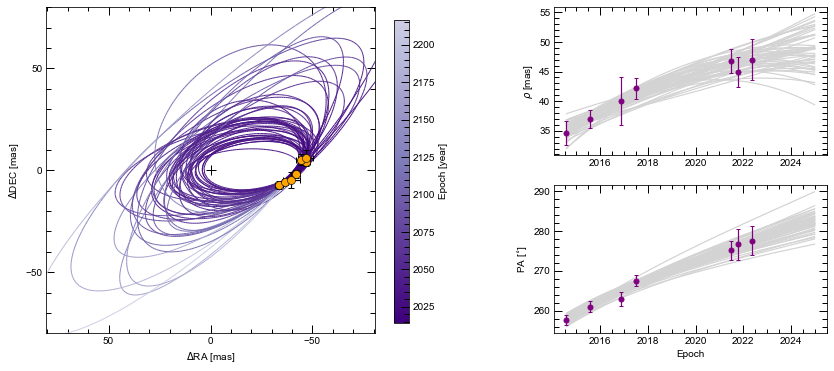

In [8]:
# plot the results
epochs = s.system.data_table['epoch']

orbit_figure = myResults.plot_orbits(
    start_mjd=epochs[0], # colorbar stars @ first data epoch
    num_orbits_to_plot=50,    # number of model orbits
    num_epochs_to_plot=200,   # number of model points
)
    
    
# pull axes objects to customize
ax_orb, ax_sep, ax_pa, ax_cbar  = orbit_figure.axes

ax_orb.set_xlim(80, -80)
ax_orb.set_ylim(-80, 80)
ax_orb.set_xlabel('$\Delta$RA [mas]')
ax_orb.set_ylabel('$\Delta$DEC [mas]')

ax_orb.plot([0], [0], marker='+', color='black', linestyle=' ', ms=10)
ax_orb.errorbar(ra, dec, era, edec, color='k', linestyle=' ')
ax_orb.plot(ra, dec, marker='o', color='orange', mec='k', mew=0.6, linestyle=' ', ms=8)


orbit_figure.savefig('orbit_vb.png', bbox_inches='tight' )


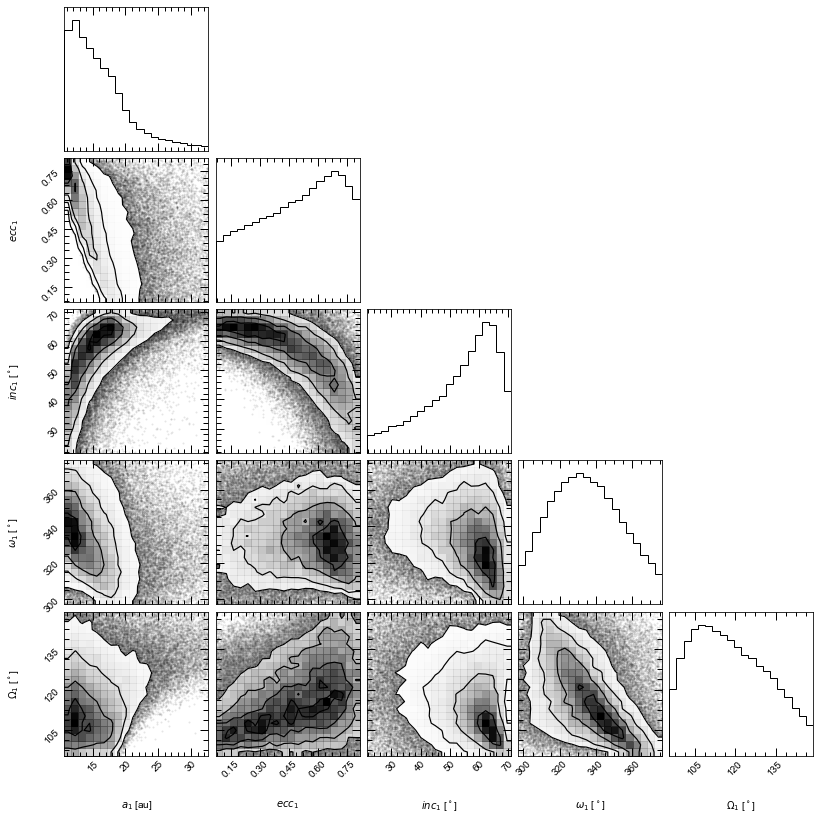

In [9]:
# corner plot with results
#   use the param_list keyword argument to plot only certain params 
corner_figure = myResults.plot_corner(
    param_list=['sma1','ecc1','inc1','aop1','pan1'],
    range=(0.90,0.90,0.90,0.90,0.90))   
# limit the panels to only display 95% of the samples to avoid showing the long tails in the distribution

corner_figure.savefig('corner.png', bbox_inches='tight' )


In [10]:
# Get histogram info

# Compute median of each parameter
median_values = np.median(myResults.post,axis=0) 

#range_values = np.ones_like(median_values)*0.95 # Plot only 95% range for each parameter
#corner_figure_median_95 = myResults.plot_corner(range=range_values, truths=median_values)

# vb orb par
best = np.zeros(7)
error = np.zeros(7)

#make histogram for each parameter and fit gaussian
from scipy.optimize import curve_fit
def gaussian(x, amp, cen, wid, height=0):
    return amp * np.exp((-1 * (x - cen)**2) / (2*wid**2))  \
        / (wid * np.sqrt(2*3.14)) + height



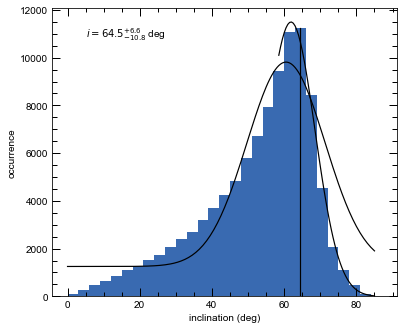

In [11]:
# INCLINATION
temp = np.array([data[s.system.param_idx['inc1']] for data in orbits])

fig = plt.figure(figsize=(6,5))
ax1 = fig.add_axes([0.10, 0.10, 0.80, 0.80]) 
n = plt.hist(temp * 180/np.pi, bins=np.arange(0, 90, 3))
plt.xlabel('inclination (deg)')
plt.ylabel('occurrence')
#plt.xlim(0, 135)

# bin centers, values
x = np.array(n[1])[0:-1]
x = x + (x[1] - x[0])/2.
y = np.array(n[0])
ibest = np.argmax(y)
inc = x[ibest]
plt.plot([inc, inc], [0,np.max(y)], color='black')

# FIT LEFT SIDE
init = [y[ibest], x[ibest], 5, 100]  # [amp, cen, wid, height]
best, covar = curve_fit(gaussian, x[0:ibest+3], y[0:ibest+3], p0=init)
xfit = np.arange(0, x[-1], 0.5)
yfit = gaussian(xfit, best[0], best[1], best[2], best[3])
plt.plot(xfit, yfit, color='black')
einc_left = abs(best[2])

# FIT RIGHT SIDE
init = [y[ibest], x[ibest], 10, 100]  # [amp, cen, wid, height]
best, covar = curve_fit(gaussian, x[ibest-3:], y[ibest-3:], p0=init)
xfit = np.arange(x[ibest-2], x[-1], 0.5)
yfit = gaussian(xfit, best[0], best[1], best[2], best[3])
plt.plot(xfit, yfit, color='black')
einc_right = abs(best[2])

ax1.text(0.10, 0.90, '$i = %3.1f ^{+ %3.1f} _{- %3.1f}$ deg' % \
         (inc, einc_right, einc_left), fontsize=10, transform=ax1.transAxes)

plt.savefig('results_param_inc.png', bbox_inches='tight' )
plt.show()
plt.close()


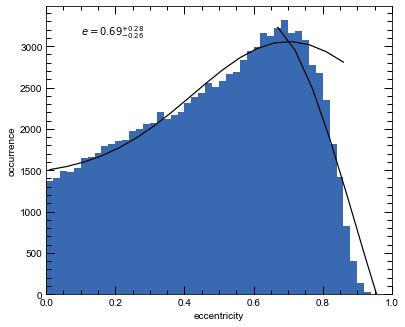

In [26]:
# ECCENTRICITY
temp = np.array([data[s.system.param_idx['ecc1']] for data in orbits])

fig = plt.figure(figsize=(6,5))
ax1 = fig.add_axes([0.10, 0.10, 0.80, 0.80]) 
n = plt.hist(temp, bins=np.arange(0, 1.005, 0.02))
plt.xlabel('eccentricity')
plt.ylabel('occurrence')
plt.xlim(0,1)
plt.ylim(0)

# bin centers, values
x = np.array(n[1])[0:-1]
x = x + (x[1] - x[0])/2.
y = np.array(n[0])
ibest = np.argmax(y)
ecc = x[ibest]

# FIT LEFT SIDE
init = [y[ibest], x[ibest], 0.2, 1500]  # [amp, cen, wid, height]
best, covar = curve_fit(gaussian, x[0:ibest+6], y[0:ibest+6], p0=init)
xfit = np.arange(x[0], x[ibest+10], 0.05)
yfit = gaussian(xfit, best[0], best[1], best[2], best[3])
plt.plot(xfit, yfit, color='black')
eecc_left = best[2]

# FIT RIGHT SIDE
init = [y[ibest], x[ibest], 0.2, 0]  # [amp, cen, wid, height]
best, covar = curve_fit(gaussian, x[ibest-12:], y[ibest-12:], p0=init)
xfit = np.arange(x[ibest-1], x[-1], 0.05)
yfit = gaussian(xfit, best[0], best[1], best[2], best[3])
plt.plot(xfit, yfit, color='black')
eecc_right = abs(best[2])

ax1.text(0.10, 0.90, '$e = %3.2f ^{+ %3.2f} _{- %3.2f}$' % (ecc, eecc_left, eecc_right), \
  fontsize=10, transform=ax1.transAxes)

plt.savefig('results_param_ecc.png', bbox_inches='tight' )
plt.show()
plt.close()

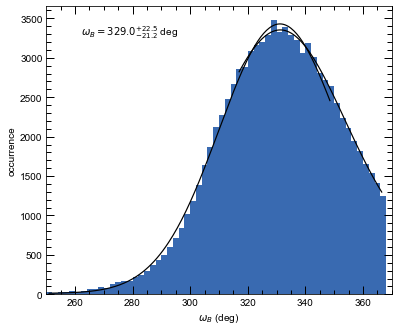

In [61]:
# LONGITUDE OF PERIASTRON B
temp = np.array([data[s.system.param_idx['aop1']] for data in orbits])
temp = temp*180/np.pi

fig = plt.figure(figsize=(6,5))
ax1 = fig.add_axes([0.10, 0.10, 0.80, 0.80]) 
n = plt.hist(temp, bins=np.arange(250, 370, 2))
plt.xlabel('$\omega_B$ (deg)')
plt.ylabel('occurrence')
plt.xlim(250, 370)
#plt.ylim(0, 3000)

# bin centers, values
x = np.array(n[1])[0:-1]
x = x + (x[1] - x[0])/2.
y = np.array(n[0])
ibest = np.argmax(y)
omega = x[ibest]

# FIT LEFT SIDE
init = [y[ibest], x[ibest], 2, 0]  # [amp, cen, wid, height]
best, covar = curve_fit(gaussian, x[0:ibest+10], y[0:ibest+10], p0=init)
xfit = np.arange(x[0], x[ibest+10], 0.5)
yfit = gaussian(xfit, best[0], best[1], best[2], best[3])
plt.plot(xfit, yfit, color='black')
eomega_left = best[2]

# FIT RIGHT SIDE
init = [y[ibest], x[ibest], 2, 0]  # [amp, cen, wid, height]
best, covar = curve_fit(gaussian, x[ibest-6:ibest+20], y[ibest-6:ibest+20], p0=init)
xfit = np.arange(x[ibest-6], x[-1], 0.5)
yfit = gaussian(xfit, best[0], best[1], best[2], best[3])
plt.plot(xfit, yfit, color='black')
eomega_right = abs(best[2])

ax1.text(0.10, 0.90, '$\omega_B = %5.1f_{- %5.1f}^{+ %5.1f}$ deg' % \
    (omega, eomega_left, eomega_right), fontsize=10, transform=ax1.transAxes)

plt.savefig('results_param_aop.png', bbox_inches='tight' )
plt.show()
plt.close()

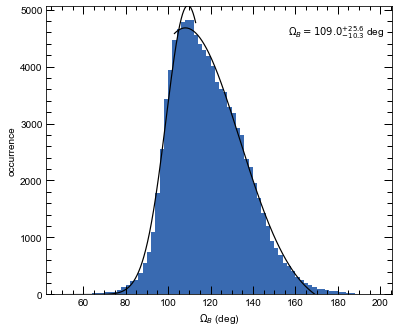

In [62]:
# LONGITUDE OF ASCENDING NODE B
temp = np.array([data[s.system.param_idx['pan1']] for data in orbits])
temp = temp*180/np.pi

fig = plt.figure(figsize=(6,5))
ax1 = fig.add_axes([0.10, 0.10, 0.80, 0.80]) 
n = plt.hist(temp, bins=np.arange(50, 200, 2))
plt.xlabel('$\Omega_B$ (deg)')
plt.ylabel('occurrence')
#plt.xlim(240, 270)
plt.ylim(0)

# bin centers, values
x = np.array(n[1])[0:-1]
x = x + (x[1] - x[0])/2.
y = np.array(n[0])
ibest = np.argmax(y)
node = x[ibest]

# FIT LEFT SIDE
init = [y[ibest], x[ibest], 2, 0]  # [amp, cen, wid, height]
best, covar = curve_fit(gaussian, x[0:ibest+5], y[0:ibest+5], p0=init)
xfit = np.arange(x[0], x[ibest+2], 0.005)
yfit = gaussian(xfit, best[0], best[1], best[2], best[3])
plt.plot(xfit, yfit, color='black')
enode_left = best[2]

# FIT RIGHT SIDE
init = [y[ibest], x[ibest], 2, 0]  # [amp, cen, wid, height]
best, covar = curve_fit(gaussian, x[ibest-3:ibest+30], y[ibest-3:ibest+30], p0=init)
xfit = np.arange(x[ibest-3], x[-1], 0.5)
yfit = gaussian(xfit, best[0], best[1], best[2], best[3])
plt.plot(xfit, yfit, color='black')
enode_right = abs(best[2])

ax1.text(0.70, 0.90, '$\Omega_B = %5.1f_{- %5.1f}^{+ %5.1f}$ deg' % \
  (node, enode_left, enode_right), fontsize=10, transform=ax1.transAxes)

plt.savefig('results_param_node.png', bbox_inches='tight' )
plt.show()
plt.close()

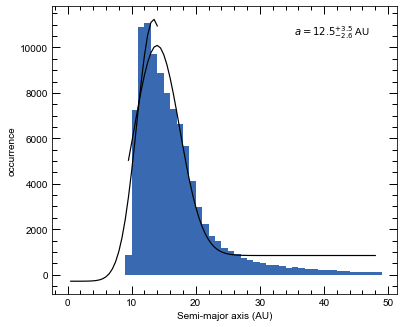

In [63]:
# SEMIMAJOR AXIS AU
temp = np.array([data[s.system.param_idx['sma1']] for data in orbits])

fig = plt.figure(figsize=(6,5))
ax1 = fig.add_axes([0.10, 0.10, 0.80, 0.80]) 
n = plt.hist(temp, bins=np.arange(0, 50, 1))
plt.xlabel('Semi-major axis (AU)')
plt.ylabel('occurrence')
#plt.xlim(240, 270)
#plt.ylim(0, 3000)

# bin centers, values
x = np.array(n[1])[0:-1]
x = x + (x[1] - x[0])/2.
y = np.array(n[0])
ibest = np.argmax(y)
alpha = x[ibest]

# FIT LEFT SIDE
init = [y[ibest], x[ibest], 2, 0]  # [amp, cen, wid, height]
best, covar = curve_fit(gaussian, x[0:ibest+5], y[0:ibest+5], p0=init)
xfit = np.arange(x[0], x[ibest+2], 0.5)
yfit = gaussian(xfit, best[0], best[1], best[2], best[3])
plt.plot(xfit, yfit, color='black')
ealpha_left = best[2]

# FIT RIGHT SIDE
init = [y[ibest], x[ibest], 2, 0]  # [amp, cen, wid, height]
best, covar = curve_fit(gaussian, x[ibest-3:ibest+20], y[ibest-3:ibest+20], p0=init)
xfit = np.arange(x[ibest-3], x[-1], 0.5)
yfit = gaussian(xfit, best[0], best[1], best[2], best[3])
plt.plot(xfit, yfit, color='black')
ealpha_right = abs(best[2])

ax1.text(0.70, 0.90, '$a = %5.1f_{- %5.1f}^{+ %5.1f}$ AU' % \
  (alpha, ealpha_left, ealpha_right), fontsize=10, transform=ax1.transAxes)

plt.savefig('results_param_alpha.png', bbox_inches='tight' )
plt.show()
plt.close()

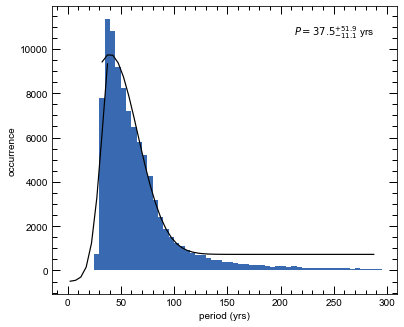

In [64]:
# PERIOD
sma = np.array([data[s.system.param_idx['sma1']] for data in orbits])  # a in AU
mtot = total_mass  # Solar masses, total mass
temp = np.sqrt(sma**3/total_mass) # years, period


fig = plt.figure(figsize=(6,5))
ax1 = fig.add_axes([0.10, 0.10, 0.80, 0.80]) 
n = plt.hist(temp, bins=np.arange(0, 300, 5))
plt.xlabel('period (yrs)')
plt.ylabel('occurrence')
#plt.xlim(240, 270)
#plt.ylim(0, 3000)

# bin centers, values
x = np.array(n[1])[0:-1]
x = x + (x[1] - x[0])/2.
y = np.array(n[0])
ibest = np.argmax(y)
p = x[ibest]

# FIT LEFT SIDE
init = [y[ibest], x[ibest], 2, 0]  # [amp, cen, wid, height]
best, covar = curve_fit(gaussian, x[0:ibest+5], y[0:ibest+5], p0=init)
xfit = np.arange(x[0], x[ibest+1], 5)
yfit = gaussian(xfit, best[0], best[1], best[2], best[3])
plt.plot(xfit, yfit, color='black')
ep_left = abs(best[2])

# FIT RIGHT SIDE
init = [y[ibest], x[ibest], 20, 0]  # [amp, cen, wid, height]
best, covar = curve_fit(gaussian, x[ibest-1:ibest+20], y[ibest-1:ibest+20], p0=init)
xfit = np.arange(x[ibest-1], x[-1], 5)
yfit = gaussian(xfit, best[0], best[1], best[2], best[3])
plt.plot(xfit, yfit, color='black')
ep_right = abs(best[2])*2

ax1.text(0.70, 0.90, '$P = %5.1f_{- %5.1f}^{+ %5.1f}$ yrs' % \
  (p, ep_left, ep_right), fontsize=10, transform=ax1.transAxes)

plt.savefig('results_param_period.png', bbox_inches='tight' )
plt.show()
plt.close()

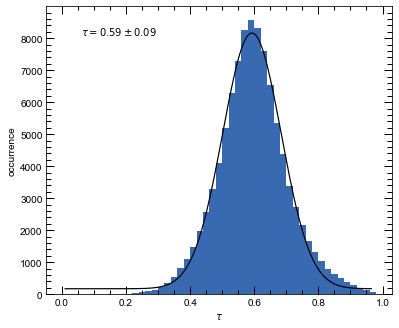

In [65]:
# TAU
temp = np.array([data[s.system.param_idx['tau1']] for data in orbits])

fig = plt.figure(figsize=(6,5))
ax1 = fig.add_axes([0.10, 0.10, 0.80, 0.80]) 
n = plt.hist(temp, bins=np.arange(0, 1, 0.02))
plt.xlabel('$\\tau$')
plt.ylabel('occurrence')
#plt.xlim(240, 270)
#plt.ylim(0, 3000)

# bin centers, values
x = np.array(n[1])[0:-1]
x = x + (x[1] - x[0])/2.
y = np.array(n[0])
ibest = np.argmax(y)
tau = x[ibest]

# FIT LEFT SIDE
init = [y[ibest], x[ibest], 2, 0]  # [amp, cen, wid, height]
best, covar = curve_fit(gaussian, x, y, p0=init)
xfit = np.arange(x[0], x[-1], 0.005)
yfit = gaussian(xfit, best[0], best[1], best[2], best[3])
plt.plot(xfit, yfit, color='black')
etau_left = best[2]

ax1.text(0.10, 0.90, '$\\tau = %5.2f \pm {%5.2f}$' % \
  (tau, etau_left), fontsize=10, transform=ax1.transAxes)

plt.savefig('results_param_tau.png', bbox_inches='tight' )
plt.show()
plt.close()

In [66]:
# Print results
print()
    
print('param          value   -err   +err')
print(' a (au)       %6.1f %6.1f %6.1f' % (alpha, ealpha_left, ealpha_right))
print(' ecc          %6.2f %6.2f %6.2f' % (ecc, eecc_left, eecc_left))
print(' inc (deg)    %6.1f %6.1f %6.1f' % (inc, einc_left, einc_right))
print(' omegaB (deg) %6.1f %6.1f %6.1f' % (omega, eomega_left, eomega_right))
print(' OmegaB (deg) %6.1f %6.1f %6.1f' % (node, enode_left, enode_right))
print(' tau          %6.2f %6.2f %6.2f' % (tau, etau_left, etau_left))
print(' period       %6.1f %6.1f %6.1f' % (p, ep_left, ep_right))
print(' plx          %6.2f %6.2f %6.2f  *priors*' % (plx, plx_err, plx_err))
print(' mtot         %6.2f %6.2f %6.2f  *priors*' % (total_mass, mass_err, mass_err))
print()

f= open('results.txt', "w")
f.write('param         value   -err   +err \n')
f.write(' a(au)       %6.1f %6.1f %6.1f \n' % (alpha, ealpha_left, ealpha_right))
f.write(' ecc         %6.2f %6.2f %6.2f \n' % (ecc, eecc_left, eecc_left))
f.write(' inc(deg)    %6.1f %6.1f %6.1f \n' % (inc, einc_left, einc_right))
f.write(' omegaB(deg) %6.1f %6.1f %6.1f \n' % (omega, eomega_left, eomega_right))
f.write(' OmegaB(deg) %6.1f %6.1f %6.1f \n' % (node, enode_right, enode_right))
f.write(' tau         %6.2f %6.2f %6.2f \n' % (tau, etau_left, etau_left))
f.write(' period      %6.1f %6.1f %6.1f \n' % (p, ep_left, ep_right))
f.write(' plx         %6.2f %6.2f %6.2f \n' % (plx, plx_err, plx_err))
f.write(' mtot        %6.2f %6.2f %6.2f \n' % (total_mass, mass_err, mass_err))

f.close()


param          value   -err   +err
 a (au)         12.5    2.6    3.5
 ecc            0.69   0.28   0.28
 inc (deg)      64.5   10.8    6.6
 omegaB (deg)  329.0   21.2   22.5
 OmegaB (deg)  109.0   10.3   25.6
 tau            0.59   0.09   0.09
 period         37.5   11.1   51.9
 plx            2.47   0.00   0.00  *priors*
 mtot           1.10   0.50   0.50  *priors*

